<h1 align=center><font size = 10>ASM 1</font></h1>

# Bài toán

Trong notebook này, chúng ta sẽ ứng dụng thuật toán hồi quy tuyến tính mà chúng ta đã học trong khóa học này.

Hãy đọc dữ liệu bằng thư viện Pandas, sau đó sử dụng thuật toán hồi quy tuyến tính với các đặc trưng khác nhau nhằm tìm ra thuật toán hồi quy tuyến tính tốt nhất thông qua phương pháp đánh giá độ chính xác.

Tập dữ liệu và bài toán thuộc dạng hồi quy cổ điển. Với một số đặc trưng nhất định, chúng ta cần xây dựng một mô hình hồi quy tuyến tính để xác định **số lượng hồ sơ được chấp nhận** dựa vào các đặc trưng đã có.

Để giải quyết bài toán này, chúng ta cần phân tích dữ liệu, thực hiện bất kỳ chuyển đổi và chuẩn hóa cần thiết nào, áp dụng thuật toán ML, huấn luyện mô hình, kiểm tra chất lượng của mô hình đã huấn luyện và lặp lại cho đến khi có được chất lượng cao nhất cho tập dữ liệu của mình.

# Pipeline 

1. Đọc dữ liệu.

2. Tiền xử lý dữ liệu.

3. Trực quan dữ liệu.

4. Chuẩn bị dữ liệu.

5. Xây dựng mô hình hồi quy tuyến tính đơn biến.

6. Xây dựng mô hình hồi quy tuyến tính đa biến.

7. Xây dựng mô hình hồi quy tuyến tính trên toàn bộ đặc trưng để quan sát mối quan hệ giữa các đặc trưng và mục tiêu.

8. Xây dựng mô hình Lasso để lựa chọn đặc trưng tốt nhất cho mục tiêu.

# Tập dữ liệu

Dự án này liên quan đến tập dữ liệu College, trong file College.csv trong thư mục dữ liệu. Nó chứa các biến sau cho 777 trường đại học và cao đẳng khác nhau ở Mỹ:

**Private**: Chỉ báo public/private

**Apps**: Số lượng hồ sơ nhận được

**Accept**: Số lượng sinh viên được chấp thuận

**Enroll**: Số sinh viên mới đăng ký

**Top10perc**: Sinh viên mới từ top 10% lớp trung học

**Top25perc**: Sinh viên mới từ top 25% lớp trung học

**F.Undergrad**: Số sinh viên đại học toàn thời gian

**P.Undergrad**: Số sinh viên đại học bán thời gian

**Outstate**: Học phí ngoại bang

**Room.Board**: Chi phí ăn ở

**Books**: Chi phí giáo trình theo ước tính

**Personal**: Chi tiêu cá nhân theo ước tính

**PhD**: Phần trăm giảng viên có bằng Tiến sĩ

**Terminal**: Phần trăm giảng viên có Terminal degree (bẳng cấp cao nhất trong một lĩnh vực nhất định)

**S.F.Ratio**: Tỷ lệ sinh viên/giảng viên

**perc.alumni**: Phần trăm cựu sinh viên đã quyên góp

**Expend**: Chi phí giảng dạy cho mỗi sinh viên

**Grad.Rate**: Tỷ lệ tốt nghiệp

# Thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

matplotlib.style.use('ggplot')

# Hàm tiện ích

Phương pháp tiện ích này sẽ giúp vẽ biểu đồ các quan sát thử nghiệm của bạn, so sánh chúng với đường hồi quy và hiển thị hệ số R2.

In [2]:
def drawLine(model, X_test, y_test, title, feature):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 1 đặc trưng
    # và hiển thị hệ số R2
    y_pred = model.predict(X_test)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_test, y_test, c='g', marker='o')
    ax.plot(X_test, y_pred, color='orange', linewidth=1, alpha=0.7)
    ax.set_xlabel(feature)
    ax.set_ylabel('Accept')

    R2 = r2_score(y_test, y_pred)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

In [3]:
def drawPlane(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
    # và hiển thị hệ số R2
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_zlabel('prediction')

    
    # Chuyển về numpy vì X_test có thể là DataFrame, v.v.
    X_test = np.array(X_test)
    col1 = X_test[:,0]
    col2 = X_test[:,1]

    
    # Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
    # để vẽ siêu mặt phẳng   
    # do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
    x_min, x_max = col1.min(), col1.max()
    y_min, y_max = col2.min(), col2.max()
    x = np.arange(x_min, x_max, (x_max-x_min) / 10)
    y = np.arange(y_min, y_max, (y_max-y_min) / 10)
    x, y = np.meshgrid(x, y)

    
    # Dự đoán để lấy siêu mặt phẳng
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)

    # Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
    ax.scatter(col1, col2, y_test, c='g', marker='o')
    ax.plot_wireframe(x, y, z, color='orange', alpha=0.7)
    
    y_pred = model.predict(X_test)
    R2 = r2_score(y_test, y_pred)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

# Task 1: Đọc dữ liệu từ tập dữ liệu College

Chỉ mục là cột tên trường đại học.

In [4]:
# Nhập code của bạn ở đây
df = pd.read_csv('College.csv', index_col = 'Unnamed: 0')
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 2: Mã hóa hạng mục 

Sử dụng map() để chuyển đổi cột Private thành {'Yes':1, 'No':0}.

Hầu hết tất cả thuật toán học máy đều không làm việc với dữ liệu chuỗi hoặc hạng mục, do đó cần chuyển đổi những loại dữ liệu này để phù hợp với đầu vào của học máy. Phương thức `.map()` giống như `.apply()`, nhưng thay vì sử dụng lambda/function, bạn chỉ cần cung cấp ánh xạ key:value.

In [5]:
# Nhập code của bạn ở đây
df.Private = df.Private.map({'Yes':1, 'No':0})
df

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Worcester State College,0,2197,1515,543,4,26,3089,2029,6797,3900,500,1200,60,60,21.0,14,4469,40
Xavier University,1,1959,1805,695,24,47,2849,1107,11520,4960,600,1250,73,75,13.3,31,9189,83
Xavier University of Louisiana,1,2097,1915,695,34,61,2793,166,6900,4200,617,781,67,75,14.4,20,8323,49
Yale University,1,10705,2453,1317,95,99,5217,83,19840,6510,630,2115,96,96,5.8,49,40386,99


# Task 3: Trực quan ma trận tương quan

Tính toán ma trận trực quan từ DataFrame

In [6]:
# Nhập code của bạn ở đây
corr_matrix = df.corr()

Trực quan ma trận trực quan bằng Seaborn

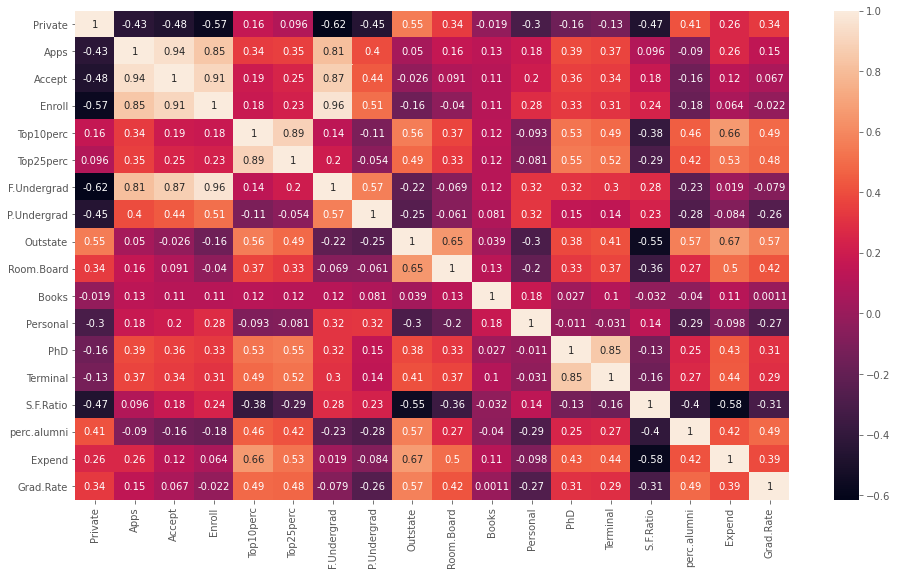

In [7]:
# Nhập code của bạn ở đây
plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True)
plt.show()

# Task 4: Vẽ biểu đồ Scatter từng đặc trưng với mục tiêu

Lấy ra toàn bộ đặc trưng từ dữ liệu và loại bỏ đi mục tiêu ("Accept")

In [8]:
# Nhập code của bạn ở đây
df_accept = df['Accept']
df.drop('Accept', axis = 1, inplace = True)
df.columns

Index(['Private', 'Apps', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
       'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate'],
      dtype='object')

Trực quan từng đặc trưng với mục tiêu

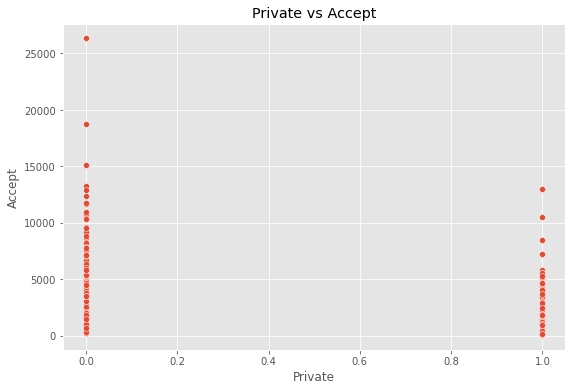

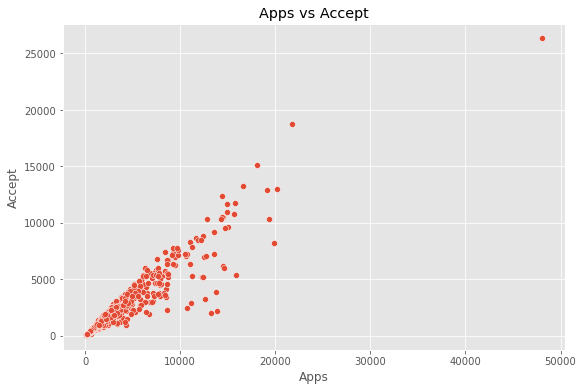

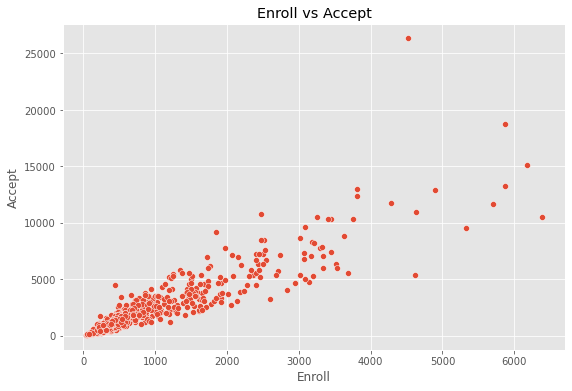

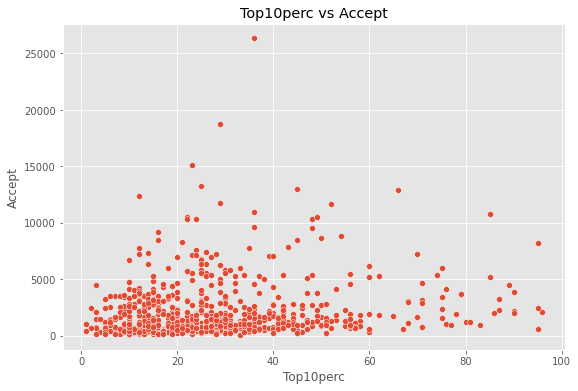

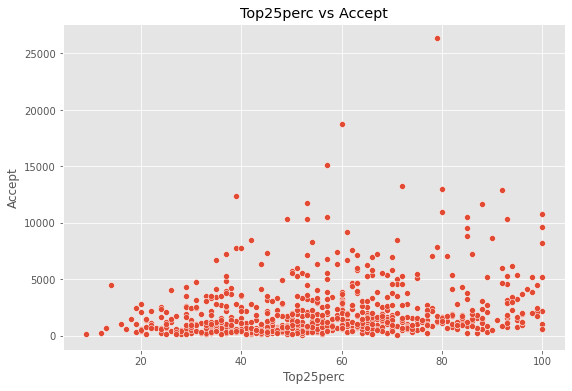

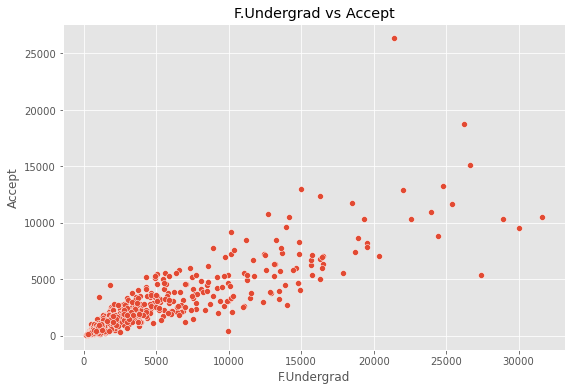

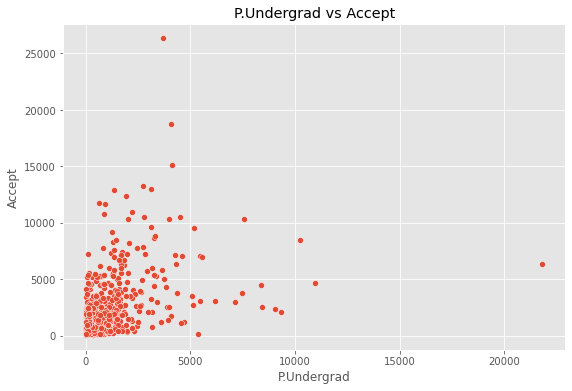

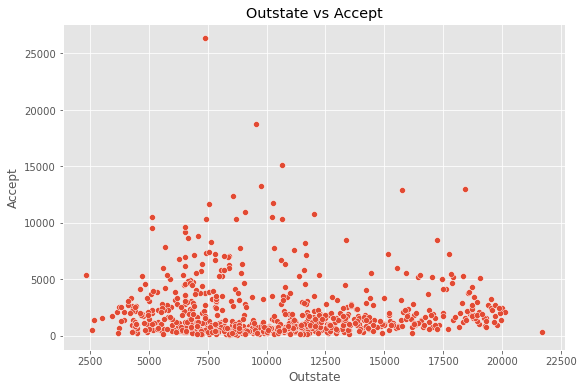

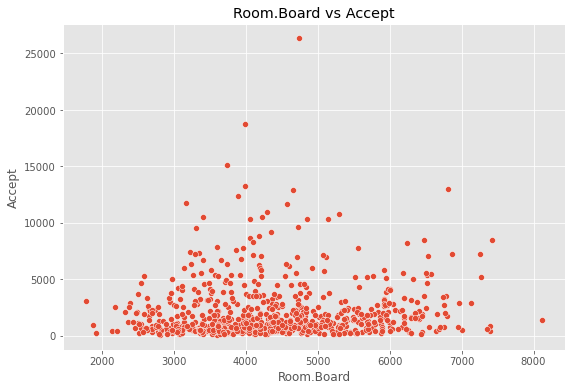

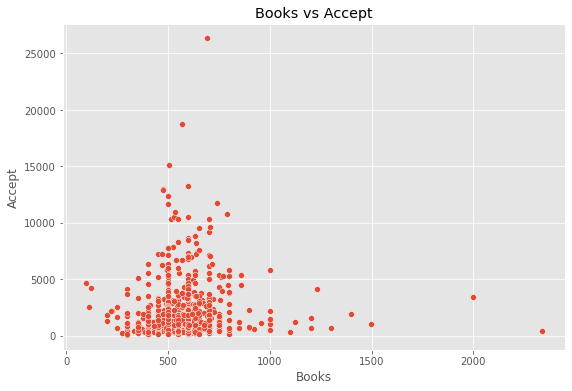

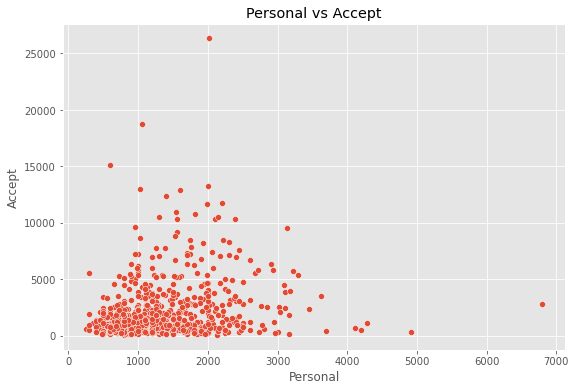

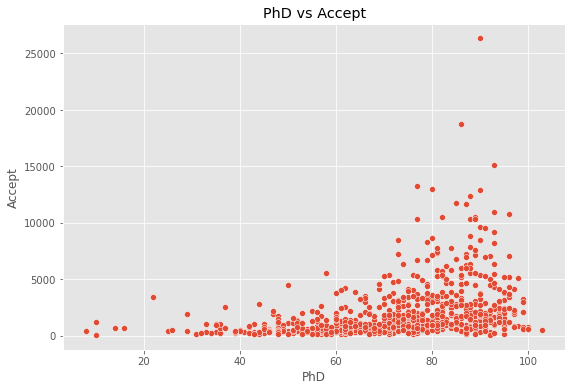

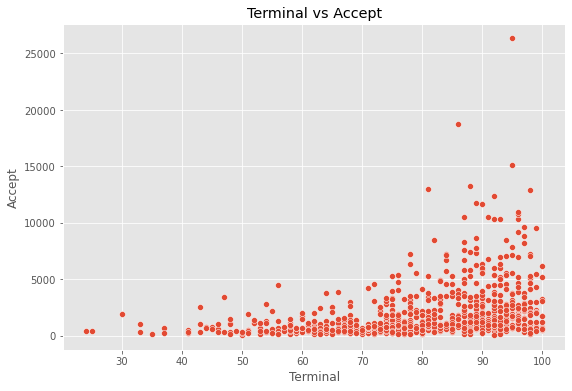

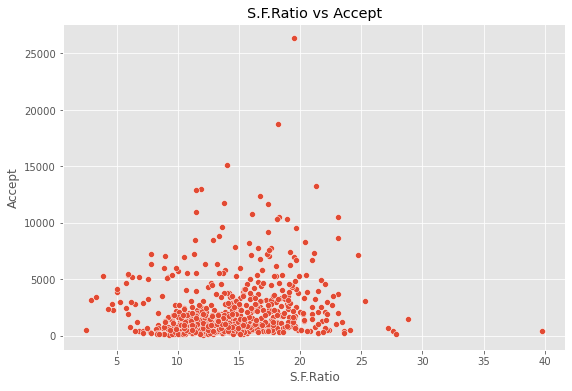

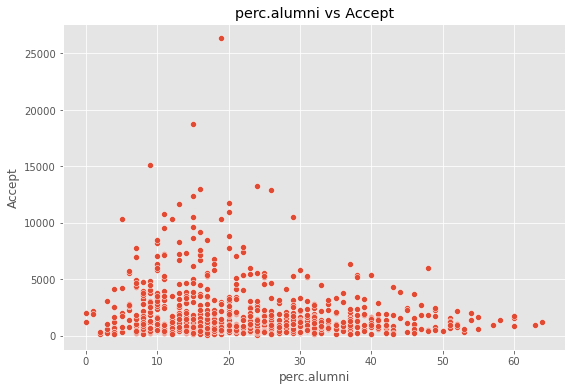

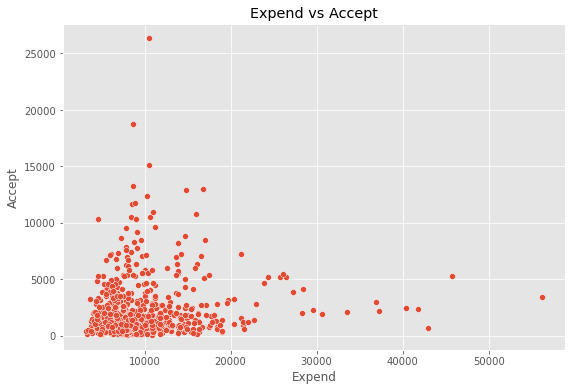

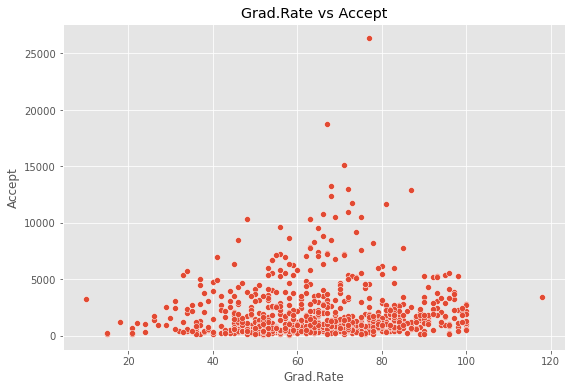

In [9]:
# Nhập code của bạn ở đây
columns = df.columns
for i in range(len(columns)):
    fig, ax = plt.subplots(figsize=(9, 6))# kích thước của biểu đồ
    sns.scatterplot(data = df, x = df.columns[i], y= df_accept)
    plt.title(columns[i] + ' ' + 'vs Accept')
    plt.show()

# Task 5: Phân tách dữ liệu đặc trưng vào X, dữ liệu mục tiêu vào y từ dữ liệu gốc


In [10]:
# Nhập code của bạn ở đây
X = df
y = df_accept

In [11]:
X.head()

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [12]:
y.head()

Abilene Christian University    1232
Adelphi University              1924
Adrian College                  1097
Agnes Scott College              349
Alaska Pacific University        146
Name: Accept, dtype: int64

# Task 6: Tách dữ liệu thành train/test data

Dữ liệu train chiếm 70% và random_state là 7.

In [13]:
from sklearn.model_selection import train_test_split

# Nhập code của bạn ở đây
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

# Task 7: Mô hình hóa hồi quy tuyến tính chi phí ăn ở và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu chi phí ăn ở từ bộ train và test

In [14]:
# Nhập code của bạn ở đây
X_train_rb = X_train[['Room.Board']]
X_test_rb = X_test[['Room.Board']]
y_train_rb = y_train.to_frame()
y_test_rb = y_test.to_frame()

Điều chỉnh shape dữ liệu phù hợp với đầu vào của mô hình

Mô hình hồi quy tuyến tính yêu cầu đầu vào có dạng là (m, n) với X và (m, 1) với y.

Trong đó:

- m là số lượng mẫu quan sát

- n là số lượng đặc trưng

Với một đặc trưng duy nhất, shape phù hợp sẽ là (m, 1) cho X.

In [15]:
# Nhập code của bạn ở đây
print(X_train_rb.shape)
print(X_test_rb.shape)
print(y_train_rb.shape)
print(y_test_rb.shape)

(543, 1)
(234, 1)
(543, 1)
(234, 1)


Xây dựng và huấn luyện mô hình

In [16]:
# Nhập code của bạn ở đây
from sklearn import linear_model
model = linear_model.LinearRegression()

model_1 = model.fit(X_train_rb, y_train_rb)
model_1

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [17]:
# Nhập code của bạn ở đây
score_1 = model_1.score(X_test_rb, y_test_rb)
score_1

-0.0026669864145500988

Trực quan mô hình hóa với dữ liệu test

R2: -0.0026669864145500988
Intercept(s):  [1340.61956519]


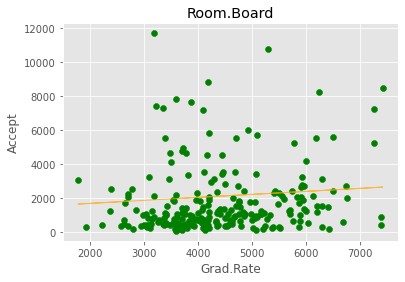

In [18]:
# Nhập code của bạn ở đây
drawLine(model_1, X_test_rb, y_test_rb, "Room.Board", 'Grad.Rate')

# Task 8: Mô hình hóa hồi quy tuyến tính số lượng sinh viên ghi danh cho mỗi trường đại học và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học ở từ bộ train và test

In [19]:
# Nhập code của bạn ở đây
X_train_Enroll = X_train[['Enroll']]
X_test_Enroll = X_test[['Enroll']]

Điều chỉnh shape phù hợp với đầu vào của mô hình

In [20]:
# Nhập code của bạn ở đây
print(X_train_Enroll.shape)
print(X_test_Enroll.shape)

(543, 1)
(234, 1)


Xây dựng và huấn luyện mô hình

In [21]:
# Nhập code của bạn ở đây
model_2 = model.fit(X_train_Enroll, y_train_rb)
model_2

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [22]:
# Nhập code của bạn ở đây
score_2 = model_2.score(X_test_Enroll, y_test_rb)
score_2

0.8578204867356156

Trực quan mô hình với dữ liệu test

R2: 0.8578204867356156
Intercept(s):  [151.72611242]


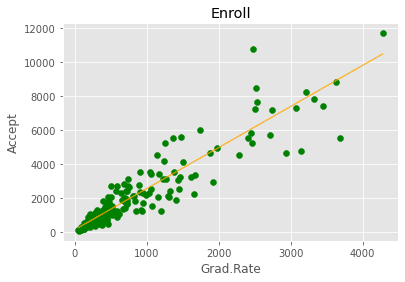

In [23]:
# Nhập code của bạn ở đây
drawLine(model_2, X_test_Enroll, y_test_rb, "Enroll", 'Grad.Rate')

# Task 9: Mô hình hóa hồi quy tuyến tính từng đặc trưng với số lượng sinh viên được chấp nhận và trực quan hóa mô hình với dữ liệu test

Lưu ý: Sử dụng vòng lặp

R2: 0.22400751013309916
Intercept(s):  [4082.93421053]


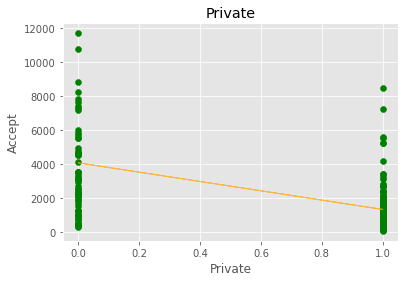

R2: 0.8278338672174985
Intercept(s):  [215.66921084]


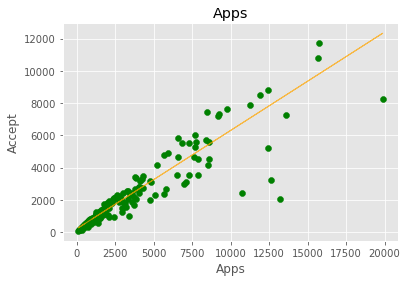

R2: 0.8578204867356156
Intercept(s):  [151.72611242]


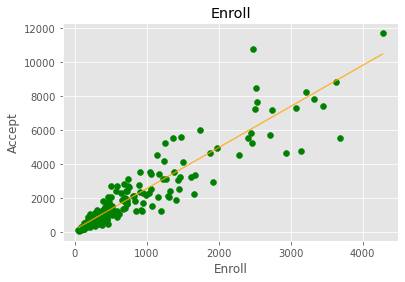

R2: 0.046531790535434436
Intercept(s):  [1397.3784276]


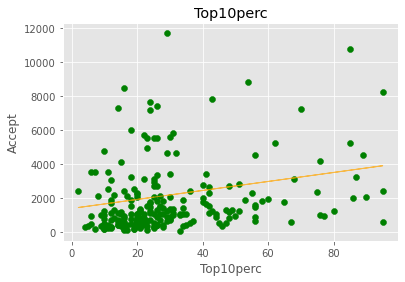

R2: 0.05631647635294579
Intercept(s):  [378.88468283]


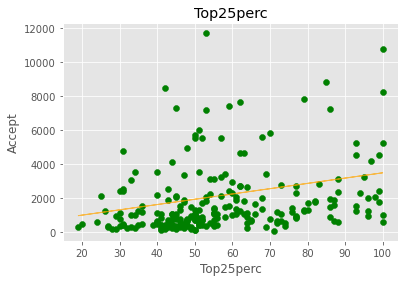

R2: 0.7779917973754006
Intercept(s):  [380.9429105]


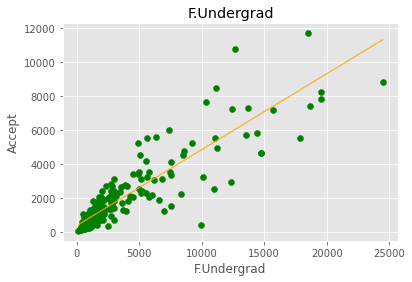

R2: 0.15365724454940077
Intercept(s):  [1444.34815175]


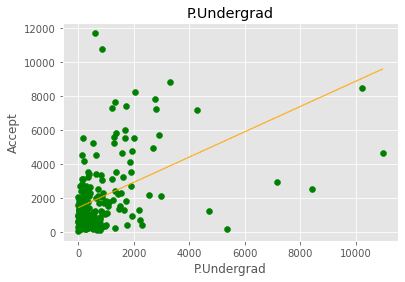

R2: -0.03441717957246193
Intercept(s):  [2472.29781157]


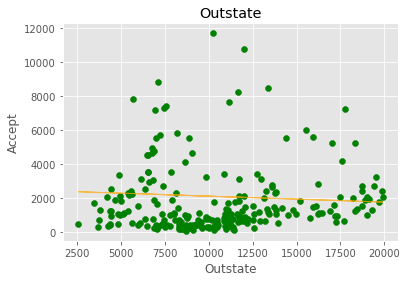

R2: -0.0026669864145500988
Intercept(s):  [1340.61956519]


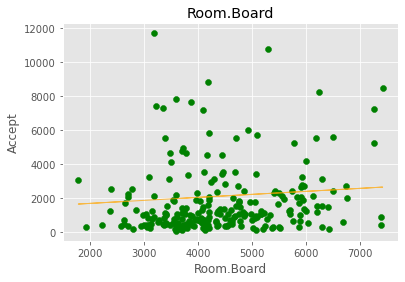

R2: 0.012015078321136241
Intercept(s):  [1304.83559562]


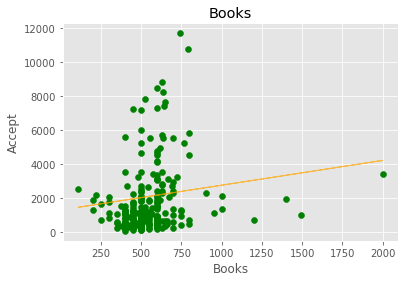

R2: 0.053082024881150325
Intercept(s):  [1185.97560794]


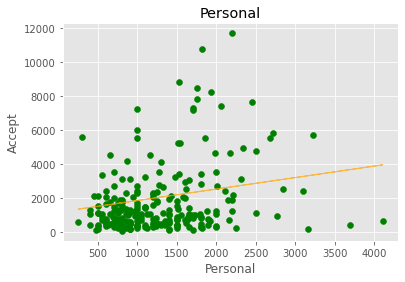

R2: 0.14442475831652202
Intercept(s):  [-1901.73568255]


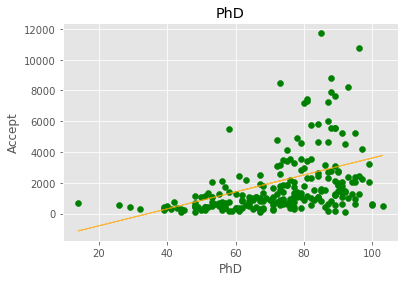

R2: 0.10721305445042717
Intercept(s):  [-2566.34112301]


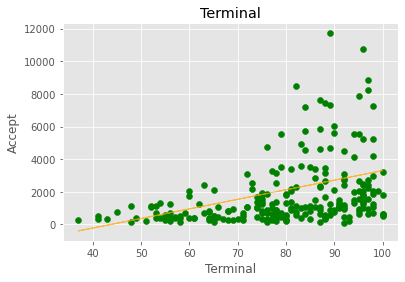

R2: -0.0012154874950456307
Intercept(s):  [406.08920302]


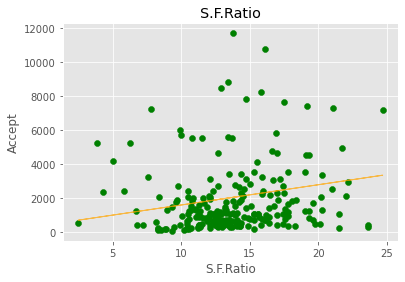

R2: 0.006075121043538134
Intercept(s):  [2869.31957079]


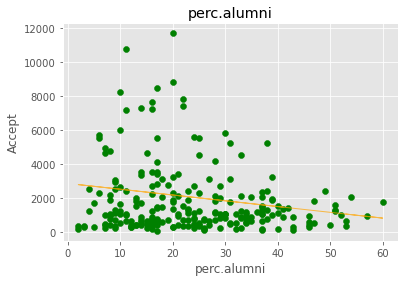

R2: 0.019419509650065114
Intercept(s):  [1652.51677722]


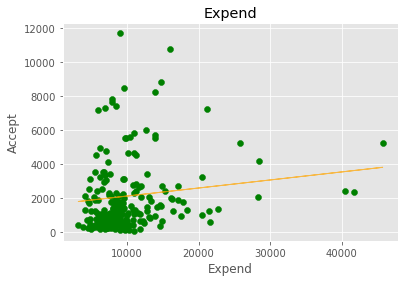

R2: -0.018954776268819362
Intercept(s):  [1407.49746019]


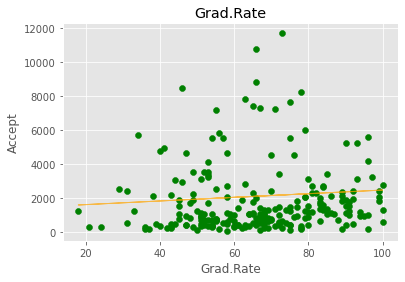

In [24]:
# Nhập code của bạn ở đây

for i in range(len(columns)):
    X_train_i = X_train[[columns[i]]]
    X_test_i = X_test[[columns[i]]]
    model_i = model.fit(X_train_i, y_train_rb) # xây dựng và huấn luyện mô hình
    score_i = model.score(X_test_i, y_test_rb)
    drawLine(model_i, X_test_i, y_test_rb, columns[i], columns[i])



# Task 10: Mô hình hóa hồi quy tuyến đa biến số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở để dự đoán số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở từ bộ train và test

In [25]:
# Nhập code của bạn ở đây
X_train__ = X_train[['Enroll', 'Room.Board']]
X_test__ = X_test[['Enroll', 'Room.Board']]


Điều chỉnh shape phù hợp với đầu vào của mô hình. 

Lưu ý dữ liệu của chúng ta ở phần này là 2 đặc trưng, do đó đầu vào của mô hình đối với X sẽ là (m, 2)

In [26]:
# Nhập code của bạn ở đây
print(X_train__.shape)
print(X_test__.shape)

(543, 2)
(234, 2)


Xây dựng và huấn luyện mô hình

In [27]:
# Nhập code của bạn ở đây
model__ = model.fit(X_train__, y_train_rb)
model__

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [28]:
# Nhập code của bạn ở đây
score__ = model__.score(X_test__, y_test_rb)
score__

0.8764371774214047

Trực quan mô hình với dữ liệu test

R2: 0.8764371774214047
Intercept(s):  [-1176.62848249]


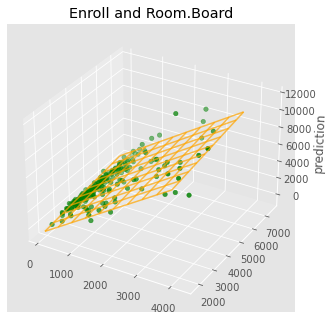

In [29]:
# Nhập code của bạn ở đây
drawPlane(model__, X_test__, y_test_rb, 'Enroll and Room.Board')

# Task 11: Sử dụng hồi quy tuyến tính với toàn bộ đặc trưng để quan sát tác động của từng đặc trưng đến mục tiêu

Tạo một bản sao về dữ liệu train và test

In [30]:
# Nhập code của bạn ở đây
list_numerical = df.columns
X_train_scaler = X_train
X_test_scaler = X_test
X_train_scaler

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Illinois Wesleyan University,1,3050,471,55,86,1818,23,14360,4090,400,650,77,92,12.9,34,9605,83
Point Park College,1,875,207,7,38,1173,1402,9700,4830,400,1200,45,90,14.5,10,7652,66
Colorado State University,0,9478,2194,29,65,15646,1829,8412,4180,470,1800,87,89,19.2,10,7850,59
Spring Arbor College,1,372,181,15,32,1501,353,8600,3550,385,665,48,48,15.4,9,10938,49
University of Rochester,1,8766,1243,56,75,5071,438,17840,6582,500,882,93,99,5.9,23,26037,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taylor University,1,1769,437,41,80,1757,81,10965,4000,450,1250,60,61,14.2,32,8294,98
Saint Olaf College,1,2248,745,38,73,2888,105,14350,3750,550,550,82,88,10.0,31,12502,83
Southwest State University,0,1047,511,13,33,2091,546,4285,2750,600,1800,58,75,16.5,31,6591,51
Fairfield University,1,4784,781,30,66,2984,1037,15000,6200,700,1100,86,90,15.1,30,11220,94


Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý rằng đầu vào của mô hình lúc này sẽ là (m, n).

In [31]:
# Nhập code của bạn ở đây
print(X_train_scaler.shape)
print(X_test_scaler.shape)

(543, 17)
(234, 17)


Trong hồi quy tuyến tính, đặc trưng có miền giá trị lớn hơn sẽ chiếm ưu thế hơn so với đặc trưng có miền giá trị nhỏ hơn. Để công bằng cho tất cả dặc trưng chúng ta sẽ áp dụng một phương pháp được gọi là co dãn đặc trưng

In [32]:
from sklearn.preprocessing import StandardScaler

# Nhập code của bạn ở đây
scaler = StandardScaler().fit(X_train_scaler)
X_train_scaler[list_numerical] = scaler.transform(X_train_scaler[list_numerical])
X_test_scaler[list_numerical] = scaler.transform(X_test_scaler[list_numerical])
X_train_scaler

<ipython-input-32-e26379d4e716>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_scaler[list_numerical] = scaler.transform(X_train_scaler[list_numerical])
C:\Users\Hades\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-32-e26379d4e716>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Illinois Wesleyan University,0.623496,-0.012633,-0.343311,1.688053,1.527125,-0.399791,-0.550472,0.994876,-0.222957,-0.960126,-1.023845,0.264736,0.835648,-0.332860,0.945735,0.005452,1.043776
Point Park College,0.623496,-0.545411,-0.612271,-1.183653,-0.870356,-0.526380,0.326435,-0.175036,0.462311,-0.960126,-0.232507,-1.705305,0.700581,0.061829,-1.011828,-0.379603,0.047385
Colorado State University,-1.603860,1.561938,1.412060,0.132545,0.478227,2.314119,0.597964,-0.498393,-0.139613,-0.508681,0.630770,0.880373,0.633048,1.221229,-1.011828,-0.340565,-0.362893
Spring Arbor College,0.623496,-0.668623,-0.638759,-0.705036,-1.170041,-0.462006,-0.340625,-0.451195,-0.723017,-1.056865,-1.002263,-1.520614,-2.135821,0.283842,-1.093394,0.268267,-0.949005
University of Rochester,0.623496,1.387530,0.443193,1.747880,0.977702,0.238649,-0.286573,1.868544,2.084728,-0.315204,-0.690044,1.249756,1.308382,-2.059625,0.048518,3.245196,0.867942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taylor University,0.623496,-0.326421,-0.377949,0.850472,1.227439,-0.411763,-0.513590,0.142548,-0.306300,-0.637665,-0.160568,-0.781849,-1.257887,-0.012175,0.782605,-0.253026,1.922944
Saint Olaf College,0.623496,-0.209087,-0.064163,0.670990,0.877807,-0.189790,-0.498328,0.992366,-0.537809,0.007257,-1.167725,0.572554,0.565514,-1.048234,0.701040,0.576626,1.043776
Southwest State University,-1.603860,-0.503279,-0.302559,-0.824690,-1.120094,-0.346211,-0.217896,-1.534493,-1.463847,0.329718,0.630770,-0.904976,-0.312420,0.555191,0.701040,-0.588790,-0.831782
Fairfield University,0.623496,0.412119,-0.027487,0.192373,0.528174,-0.170949,0.094331,1.155551,1.730982,0.974640,-0.376387,0.818809,0.700581,0.209838,0.619475,0.323866,1.688499


Xây dựng và huấn luyện mô hình

In [33]:
# Nhập code của bạn ở đây
model_scaler = model.fit(X_train_scaler, y_train_rb)
model_scaler

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [34]:
# Nhập code của bạn ở đây
Scored_scaler = model_scaler.score(X_test_scaler, y_test_rb)
Scored_scaler

0.919628527456307

Quan sát trong số đối với từng đặc trưng để kiểm tra xem đặc trưng nào có tác động mạnh hơn tới số lượng sinh viên được chấp nhận.

Đối chiếu trọng số của từng đặc trưng với ma trận trực quan để đối chiếu kết quả, nếu giá trị trong ma trận tương quan là dương lớn thì tham số đối với đặc trưng đó sẽ lớn và ngược lại.

Để hoàn thành được phần này, bạn hãy tham khảo và tìm ra cách lấy trọng số cho các đặc trưng từ [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) của Sklearn

In [35]:
# Nhập code của bạn ở đây
reg_scaler = LinearRegression().fit(X_train_scaler, y_train_rb)
coef = reg_scaler.coef_
lst = [] # list chứa coefidients
for i in coef:
    for j in i:
        lst.append(j)        
coef_df = pd.DataFrame({'title': columns, 'coefficients': lst})
coef_df.sort_values(by = [ 'coefficients']) # sắp xếp dữ liệu tăng dần

,title,coefficients
3,Top10perc,-497.683550
15,Expend,-160.924662
5,F.Undergrad,-153.254558
14,perc.alumni,-62.339947
6,P.Undergrad,-57.395226
13,S.F.Ratio,-36.078715
16,Grad.Rate,-26.608065
10,Personal,-19.553777
8,Room.Board,-12.106168
9,Books,-4.996008


**Câu hỏi: Đặc trưng nào có tác động mạnh nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời): Apps

**Câu hỏi: Đặc trưng nào có tác động ít nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời): Top10perc

# Task 12: Xây dựng mô hình hồi quy tuyến tính của riêng bạn

Tùy ý chọn đặc trưng và điều chỉnh siêu tham số

Yêu cầu: R2 score >= 0.9


R2: 0.9109574356266099
Intercept(s):  [2.48817147]


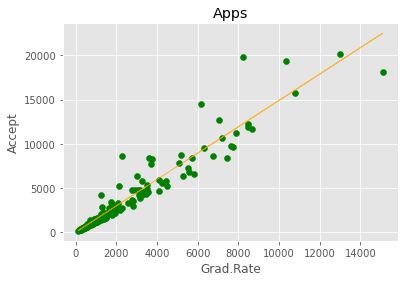

In [36]:
# Nhập code của bạn ở đây
s1 = y.to_frame()
s2 = df[['Apps']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(s1, s2, test_size = 0.2, random_state = 6)

model1 = model.fit(X_train1, y_train1)
score1 = model1.score(X_test1, y_test1)
drawLine(model1, X_test1, y_test1, 'Apps', 'Grad.Rate')

**Câu hỏi: Hãy giải thích quá trình lý do lựa chọn đặc trưng, các tham số điều chỉnh để đạt được R2 score >= 0.9**

Trả lời (nhấn vào đây để trả lời): đặc trưng lựa chọn là Apps (Số lượng hồ sơ nhận được) bởi vì tỉ lệ phân bố các điểm của các trường đại học là phân bố đều theo thứ tự tăng dần. Do đó khi vẽ đường hồi quy tuyến tính thì khoảng cách từ các điểm tới đường hồi quy tuyến tính là nhỏ nhất. Thêm vào đó sử dụng dữ liệu train là 80% và random_state = 6 

# Task 13: Sử dụng hồi quy Lasso để chọn ra đặc trưng tốt nhất để dự đoán số lượng sinh viên được chấp nhận.

Hồi quy Lasso là hồi quy tuyến tính đặc biệt được tinh chỉnh để có thể đưa các tham số của các đặc trưng không quan trọng tiến về 0 và còn lại các đặc trưng quan trọng.

Alpha càng lớn, tham số của các đặc trưng không quan trọng càng nhỏ và tiến về 0 nhanh.

Yêu cầu: Tìm giá trị alpha sao cho mô hình đạt R2 score >= 0.92

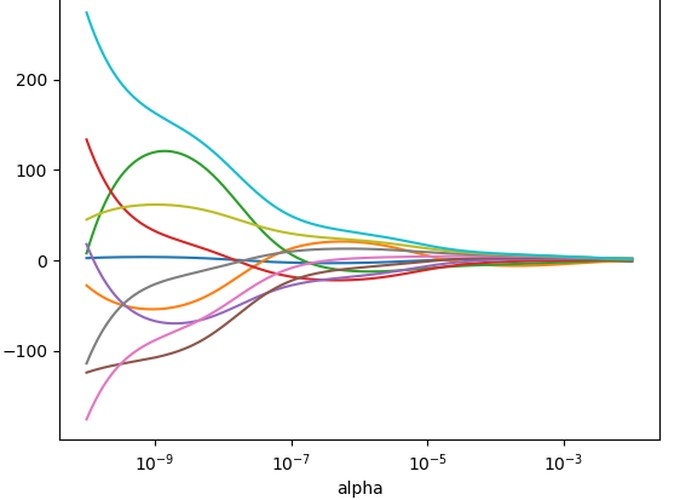

In [37]:
from sklearn.linear_model import Lasso
# Nhập code của bạn ở đây
reg = Lasso(alpha=1)
reg.fit(X_train, y_train_rb)


Lasso(alpha=1)

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [38]:
# Nhập code của bạn ở đây
print('R squared training set', round(reg.score(X_train, y_train_rb)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test_rb)*100, 2))

R squared training set 96.06
R squared test set 92.01


Quan sát tham số với từng đặc trưng để kiểm tra xem đặc trưng nào bị loại bỏ bằng phương pháp Lasso

[  -0.         1412.83758931  682.93640861   -0.           -0.
    0.            0.           -0.            0.            0.
    0.            0.            0.            0.           -0.
   -0.           -0.        ]


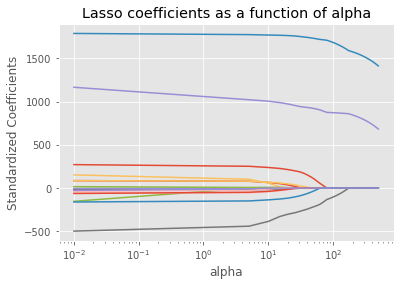

In [39]:
# Nhập code của bạn ở đây
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train_rb)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')
print(lasso.coef_)

**Câu hỏi: Đặc trưng nào bị loại bỏ trong hồi quy Lasso ?**

Trả lời (nhấn vào đây để trả lời): Trừ đặc trưng Apps và Enroll ra thì tất cả các đặc trưng còn lại bị loại bỏ